# Rethinking Statistics course in Python - Week 4

Lecture 7: Ulysses' Compass

- [Video](https://www.youtube.com/watch?v=0Jc6Kgw5qc0)
- [Slides](https://speakerdeck.com/rmcelreath/l07-statistical-rethinking-winter-2019)

Lecture 8: Model Comparison

- [Video](https://youtu.be/gjrsYDJbRh0)
- [Slides](https://speakerdeck.com/rmcelreath/l08-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04_solutions.pdf) for the exercises of the week.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
from scipy import stats
from sklearn import preprocessing

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

## Exercise 1

> Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

In [2]:
data = [['Island 1', 0.2, 0.2, 0.2, 0.2, 0.2], ['Island 2', 0.8, 0.1, 0.05, 0.025, 0.025], ['Island 3', 0.05, 0.15, 0.7, 0.05, 0.05]] 
df = pd.DataFrame(data, columns = ['Island', 'Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'])
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E
0,Island 1,0.20,0.20,0.20,0.200,0.200
1,Island 2,0.80,0.10,0.05,0.025,0.025
2,Island 3,0.05,0.15,0.70,0.050,0.050


> Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky.
First, compute the entropy of each island's birb distribution. Interpret these entropy values.

> Second, use each island's birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?

In [3]:
df['entropy']= -(df[df.columns[1:]]*np.log(df[df.columns[1:]])).sum(axis=1)

for i in range(3):
    df[f'entropy_model{i+1}']= (df[df.columns[1:6]]*(np.log(df[df.columns[1:6]]) - np.log(df[df.columns[1:6]]).loc[i,])).sum(axis=1)

In [4]:
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E,entropy,entropy_model1,entropy_model2,entropy_model3
0,Island 1,0.20,0.20,0.20,0.200,0.200,1.609438,0.000000,0.970406,0.638760
1,Island 2,0.80,0.10,0.05,0.025,0.025,0.743004,0.866434,0.000000,2.010914
2,Island 3,0.05,0.15,0.70,0.050,0.050,0.983600,0.625838,1.838845,0.000000


The first island has the largest entropy, followed by the third, and then the second in last place. Why is this? Entropy is a measure of the evenness of a distribution. The first islands has the most even distribution of birbs. This means you wouldn’t be very surprised by any particular birb. The second island, in contrast, has a very uneven distribution of birbs. If you saw any birb other than the first species, it would be surprising. Now we need K-L distance, so let’s write a function for it (_I already did in the previous cell_).

This is the distance from q to p, regarding p as true and q as the model. Now to use each island as a model of the others, we need to consider the different ordered pairings. The way to read this is each row as a model and each column as a true distribution (_I did it the opposite way because I think it's clearer, but it's the same information: each row is an island, each column is a model_). So the first island, the first row (_the first column here, the one named_ `entropy_model1`), has the smaller distances to the other islands. This makes sense, since it has the highest entropy. Why does that give it a shorter distance to the other islands? Because it is less surprised by the other islands, due to its high entropy.

## Exercise 2

> Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

_We start as always getting and processing the data:_

In [39]:
d = pd.read_csv('../../data/happiness.csv', header=0)
d.head()

,age,married,happiness
0,65,0,-2.000000
1,65,0,-1.789474
2,65,1,-1.578947
3,65,0,-1.368421
4,65,0,-1.157895


In [40]:
d = d.loc[d.age > 17,]
d['age'] = ( d['age'] - 18 ) / ( 65 - 18 )
d['married'] = d['married'].astype('Int64')

_Model 6.9 from the book:_

In [60]:
married = theano.shared(np.array(d.married))

with pm.Model() as model_69:
    # Data
    age = pm.Data('age', d['age'].values)
    #married = pm.Data('married', d['married'].values)
    happiness = pm.Data('happiness', d['happiness'].values)
    
    # Priors
    a = pm.Normal('a', mu=0, sd=1, shape=2)
    bA = pm.Normal('bA', mu=0, sd=2)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a[married] + bA * age
    happy_hat = pm.Normal('happy_hat', mu=mu, sd=sigma, observed=happiness)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior_69 = pm.sample()
    posterior_pred_69 = pm.sample_posterior_predictive(posterior_69)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
100%|██████████| 2000/2000 [01:05<00:00, 30.58it/s]


In [61]:
az.summary(posterior_69, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.23,0.07,0.0,0.0,-0.34,-0.13,984.0,984.0,986.0,1164.0,1.01
a[1],1.26,0.09,0.0,0.0,1.12,1.40,1067.0,1058.0,1069.0,995.0,1.01
bA,-0.75,0.12,0.0,0.0,-0.94,-0.58,903.0,897.0,903.0,1070.0,1.01
sigma,0.99,0.02,0.0,0.0,0.96,1.03,1643.0,1643.0,1661.0,1346.0,1.00


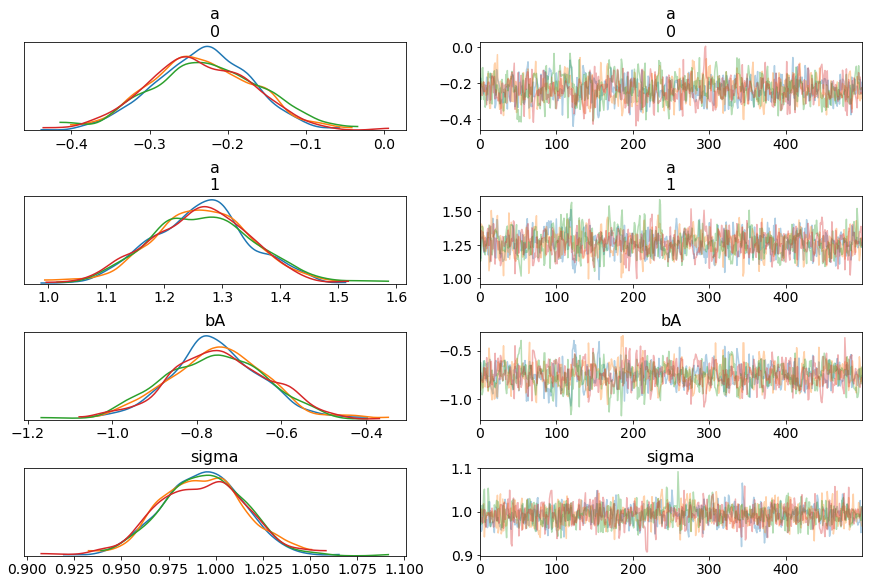

In [62]:
pm.traceplot(posterior_69);

_Model 6.10 from the book:_

In [63]:
with pm.Model() as model_610:
    # Data
    age = pm.Data('age', d['age'].values)
    happiness = pm.Data('happiness', d['happiness'].values)
    
    # Priors
    a = pm.Normal('a', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=2)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + bA * age
    happy_hat = pm.Normal('happy_hat', mu=mu, sd=sigma, observed=happiness)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior_610 = pm.sample()
    posterior_pred_610 = pm.sample_posterior_predictive(posterior_610)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
100%|██████████| 2000/2000 [01:04<00:00, 30.95it/s]


In [64]:
az.summary(posterior_610, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,0.0,0.0,-0.12,0.11,969.0,845.0,965.0,894.0,1.0
bA,0.00,0.13,0.0,0.0,-0.21,0.20,915.0,915.0,921.0,926.0,1.0
sigma,1.22,0.03,0.0,0.0,1.17,1.26,1312.0,1308.0,1303.0,1128.0,1.0


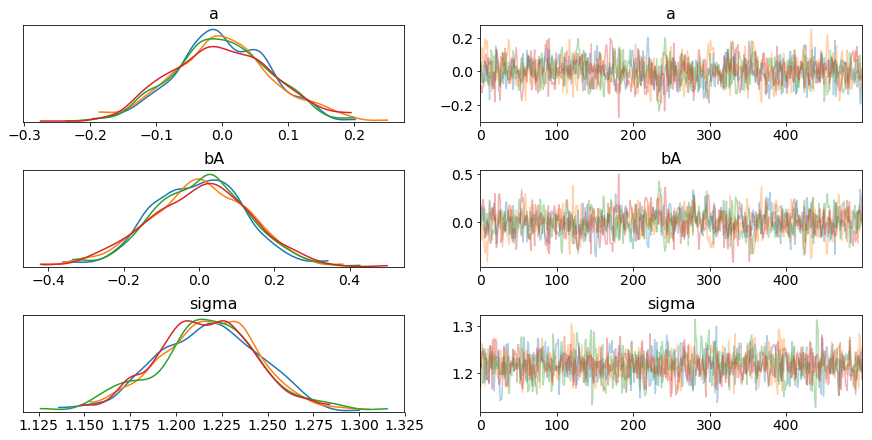

In [65]:
pm.traceplot(posterior_610);

I won't repeat the models here. They are in the text (_I just did both_). Model m6.9 contains both marriage status and age. Model m6.10 contains only age. Model m6.9 produces a confounded inference about the relationship between age and happiness, due to opening a collider path. To compare these models using WAIC:

In [66]:
model_69.name = 'model_69'
model_610.name = 'model_610'

In [67]:
pm.compare({model_69: posterior_69, model_610: posterior_610})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model_69,2713.78,3.64,0,0.99,37.3,0,0
model_610,3101.84,2.31,388.07,0.01,27.57,35.19,0


The model that produces the invalid inference, m6.9, is expected to predict much better. And it would. This is because the collider path does convey actual association. We simply end up mistaken about the causal inference. We should not use WAIC (or LOO) to choose among models, unless we have some clear sense of the causal model. These criteria will happily favor confounded models.

## Exercise 3

> Reconsider the urban fox analysis from last week's homework. Use WAIC or LOO based model comparison on five different models, each using `weight` as the outcome, and containing these sets of predictor variables:

>1. `avgfood` + `groupsize` + `area`
2. `avgfood` + `groupsize`
3. `groupsize` + `area`
4. `avgfood`
5. `area`

In [68]:
d = pd.read_csv('../../data/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


Standarise the data first of all:

In [69]:
d[['avgfood','groupsize','area','weight']] = preprocessing.scale(d[['avgfood','groupsize','area','weight']])
d.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


_Let's define the data outside of the models to make the code a bit shorter. We could do it all within one model defining different $mu$ and_ `weight_hat` _and the code would be shorter but a bit messier so let's do it model by model._

In [70]:
avgfood = theano.shared(np.array(d.avgfood))
groupsize = theano.shared(np.array(d.groupsize))
area = theano.shared(np.array(d.area))
weight = theano.shared(np.array(d.weight))

_Models_

In [71]:
with pm.Model() as model_1:
    # Priors
    a = pm.Normal('alpha', mu=0, sd=0.2)
    b = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b[0] * avgfood + b[1] * groupsize + b[2] * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

posterior_1 = posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:55<00:00, 76.19it/s]


In [72]:
with pm.Model() as model_2:
    # Priors
    a = pm.Normal('alpha', mu=0, sd=0.2)
    b = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b[0] * avgfood + b[1] * groupsize
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

posterior_2 = posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:55<00:00, 71.80it/s]


In [73]:
with pm.Model() as model_3:
    # Priors
    a = pm.Normal('alpha', mu=0, sd=0.2)
    b = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b[1] * groupsize + b[2] * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

posterior_3 = posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:53<00:00, 74.64it/s]


In [74]:
with pm.Model() as model_4:
    # Priors
    a = pm.Normal('alpha', mu=0, sd=0.2)
    b = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b[0] * avgfood
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

posterior_4 = posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:57<00:00, 69.93it/s]


In [75]:
with pm.Model() as model_5:
    # Priors
    a = pm.Normal('alpha', mu=0, sd=0.2)
    b = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b[2] * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

posterior_5 = posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:56<00:00, 70.95it/s]


In [76]:
model_1.name = 'model_1'
model_2.name = 'model_2'
model_3.name = 'model_3'
model_4.name = 'model_4'
model_5.name = 'model_5'

In [78]:
pm.compare({model_1: posterior_1,
            model_2: posterior_2,
            model_3: posterior_3,
            model_4: posterior_4,
            model_5: posterior_5})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model_1,323.82,4.46,0,0,15.47,0,1
model_3,324.49,3.44,0.67,0.5,15.07,2.67,1
model_2,324.56,3.44,0.73,0.5,15.34,3.41,0
model_4,334.21,2.25,10.39,0,13.29,6.73,0
model_5,334.39,2.42,10.56,0,13.22,6.78,0


To remind you, the DAG from last week is:

<img src="../../images/w1_img1.png" width="60%">

Notice that the top three models are m1, m3, and m2. They have very similar WAIC values. The differences are small and smaller in all cases than the standard error of the difference. WAIC sees these models are tied. This makes sense, given the DAG, because as long as a model has `groupsize` in it, we can include either `avgfood` or `area` or both and get the same inferences. Another way to think of this is that the influence of good, adjusting for `groupsize`, is (according to the DAG) the same as the influence of `area`, adjusting for `groupsize`, because the influence of `area` is routed entirely through `avgfood` and `groupsize`. There are no back-door paths.

What about the other two models, m4 and m5? These models are tied with one another, and both omit `groupsize`. Again, the influence of `area` passes entirely through `avgfood`. So including only `avgfood` or only `area` should produce the same inference; the total causal influence of `area` (or `avgfood`) is just about zero. That's indeed what the posterior distributions suggest:

In [82]:
az.summary(posterior_4, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.08,0.00,0.00,-0.14,0.13,5711.0,1941.0,5708.0,3033.0,1.0
beta[0],-0.02,0.09,0.00,0.00,-0.18,0.12,5697.0,2379.0,5733.0,3450.0,1.0
beta[1],-0.00,0.50,0.01,0.01,-0.80,0.80,6097.0,2089.0,6045.0,3329.0,1.0
beta[2],-0.01,0.49,0.01,0.01,-0.73,0.85,5736.0,1996.0,5707.0,3414.0,1.0
sigma,1.01,0.07,0.00,0.00,0.91,1.11,6977.0,6921.0,6974.0,3053.0,1.0


In [83]:
az.summary(posterior_5, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.08,0.00,0.00,-0.15,0.12,4813.0,2356.0,4815.0,3251.0,1.0
beta[0],-0.01,0.49,0.01,0.01,-0.83,0.76,5635.0,2167.0,5685.0,3354.0,1.0
beta[1],0.00,0.50,0.01,0.01,-0.79,0.80,5662.0,2381.0,5676.0,3390.0,1.0
beta[2],0.02,0.09,0.00,0.00,-0.12,0.16,6021.0,2518.0,5974.0,3346.0,1.0
sigma,1.01,0.07,0.00,0.00,0.91,1.12,5047.0,4925.0,5254.0,3271.0,1.0
